In [3]:
from __future__ import division

import astropy
import cStringIO
import glob
import ibmseti
import io
import json
import numpy as np
import matplotlib.pyplot as plt
import obspy
import os
import requests
import scipy
import zipfile

from obspy.core import read
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger 
from astropy.convolution import convolve, Box1DKernel
from scipy import ndimage

import pandas as pd
import cv2
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, cross_validation, svm, neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import RandomizedPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report

'''
IF YOU ARE RUNNING A NEWER VERSION OF MATPLOTLIB THIS CODE WILL NOT RUN:
pip install 'matplotlib==1.4.3'
Then run this code with:
python processors/sanjoy_seismogram.py
''';

In [5]:
# Find the data in the zip file
mydatafolder = '../data'
zz = zipfile.ZipFile(os.path.join(mydatafolder, 'basic4.zip'))
basic4list = zz.namelist() #list of all the image files 
firstfile = basic4list[1400] #for testing 

label_csv = pd.read_csv('../data/public_list_basic_v2_26may_2017.csv') #labels for basic4 data 
label_csv.index = label_csv.UUID #make ID the index

Here I just converted the SETI and Sanjoy's image processing algortims into functions so that they are easier to use and reference later in the code. 

In [6]:
def spectrogram_raw(in_file):
    '''
    raw np array of spectrogram 
    '''
    
    # Read data into ibmseti object
    aca = ibmseti.compamp.SimCompamp(zz.open(in_file).read())

    # Get the raw complex data
    complex_data = aca.complex_data()
    complex_data = complex_data.reshape(32, 6144)
    cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
    spectrogram = np.abs(cpfft)**2
    
    return spectrogram


def seismogram(in_file):    
    '''
    Sanjoy's Seismogram image processing function 
    Create binary image of highly denoised spectrogram 
    '''
    
    # Read data into ibmseti object
    aca = ibmseti.compamp.SimCompamp(zz.open(in_file).read())

    # Get the raw complex data
    complex_data = aca.complex_data()
    complex_data = complex_data.reshape(32, 6144)
    cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
    spectrogram = np.abs(cpfft)**2

    # Create a new empty spectrogram to contain the smooth spedtrogram values
    smoothedspectro=np.zeros(np.shape(spectrogram))

    # Apply seismogram filtering to data
    for i in range(np.shape(spectrogram)[0]):
        background = convolve(spectrogram[i], Box1DKernel(100))
        smoothedspectro[i]=spectrogram[i] - background
        df = 20
        cft = classic_sta_lta(smoothedspectro[i], int(5 * df), int(10 * df))
        indices_ut = np.where(cft>1.7)
        indices_ut = list(indices_ut[0])
        indices_lt = np.where(cft<0.2)
        indices_lt  = list(indices_lt[0])
        indices = indices_ut + indices_lt
        indices_zero = range(0,6144)
        indices_zero = list(set(indices_zero) - set(indices)) #NOTE I (mohit) got rid of the for loop here for speed 
        smoothedspectro[i][indices_zero] = 0
        smoothedspectro[i][indices_ut] = 1
        smoothedspectro[i][indices_lt] = 1
        smoothedspectro[i][:500] = 0

    # Binarize the image
    ndimage.binary_erosion(np.asarray(smoothedspectro), structure=np.ones((100,100))).astype(np.int)
    
    return smoothedspectro

#     #Plot siesmo spectrogram
#     fig, ax = plt.subplots(figsize=(8, 4))
#     cmap = plt.cm.get_cmap("binary")
#     ax.imshow(spectrogram, cmap=cmap,aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])
#     ax.set_axis_off()

#     # Plot raw spectrogram
#     spectrogram = aca.get_spectrogram()
#     fig, ax = plt.subplots(figsize=(8, 4))
#     ax.imshow(np.log(spectrogram), aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])

#     plt.show()

# Data Preprocessing

My goal with this analyis is to use MNIST classifiers as a prototype for spectrograms. I want to get the data in the same format as the MNIST dataset: (one csv/dataframe) so I can apply similar machine learning techniques. I'll need to flatten the numpy arrays of the spectrograms into one dimension, and associate the correct label with the image. I'm also going to compress the image with openCV (computer vision library) so that the models train faster. 

In [7]:
process = False #toggle to convert. Takes a LONG time so only do this if necessary. 

if process == True: 
    label_list =[] #classes 
    IDs = [] #this the random string of digits and letters
    all_images = np.empty((0,900), int) #array of our flattend images (12288)
    size = len(basic4list)

    for i, image in enumerate(basic4list): 
        #aca = ibmseti.compamp.SimCompamp(zz.open(image).read())

        #create flattend, compressed image of seismo/spectrogram for csv 
        s = seismogram(image) #NOTE: original shape is 32 x 6144
        l = int(s.shape[0]/4)
        w = int(s.shape[1]/4)
        
        s = cv2.resize(s, (30, 30)) #NOTE: new shape is 8 x 1536
        s = s.flatten()
        all_images = np.vstack((all_images,s)) #append image on vertical axis 

        ID = basic4list[i].split('.dat')[0]
        row = label_csv.loc[[ID]]
        label = row.SIGNAL_CLASSIFICATION.values[0] #get value 
        label_list.append(label)
        IDs.append(ID)
        
        
        progress = float(i)/float(size)*100
        if progress/10 == 0: 
            print progress, '% completed'

    data = np.array([label_list, IDs]).T #labels 
    data = np.hstack((data,all_images)) #add flattened image 
    labels_sorted = pd.DataFrame(data=data)
    labels_sorted.to_csv('flattend_square.csv', index=False)\
    
else: 
    print "Toggle ON/OFF. Process at your own (computational) cost"

In [8]:
#split data into features (images) and classes (labels)
full_df = pd.read_csv('flattend_square.csv')
labels = full_df.iloc[:, 0]
names = full_df.iloc[:, 1]
images = full_df.iloc[:, 2:]
images[images>0]=1  #convert back to binary (compression changed that)

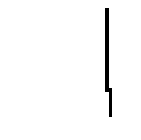

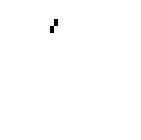

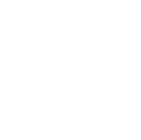

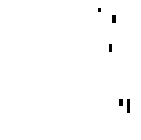

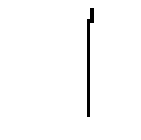

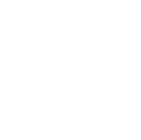

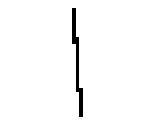

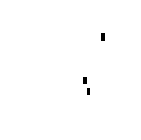

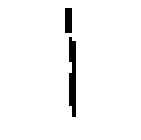

In [9]:
#plot to ensure the data didn't get comprimised. 
for i in range(1,10):
    fig, ax = plt.subplots(figsize=(4, 2))
    cmap = plt.cm.get_cmap("binary")
    spectrogram = (images.iloc[i].values).reshape(30, 30) #8, 1536
    ax.imshow(spectrogram, cmap=cmap)#,aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])
    ax.set_axis_off()
    
#     plt.subplot(1,2,1)
#     array = (images.iloc[i].values).reshape(8, 1536)
#     plt.imshow(array, cmap = plt.cm.gray_r, interpolation='nearest')

#     plt.subplot(1,2,2)
#     plt.hist(images.iloc[i])
    plt.show() #UNCOMMENT TO SHOW 

# MNIST Comparison 

My initial idea was to upcycle some of the same machine leanrning principles/code I used on the [MNIST handwritten digit dataset](https://rodrigob.github.io/are_we_there_yet/build/images/mnist.png?1363085077). The dataset consists of black lines and curves on a white canvas, just like ours. I applied some basic out-of-the-box machine learning algortihms on the dataset, and then tuned the hyperparameters (tuning knobs of an ML model) using a brute force technique called Grid Search. The Grid Search technique gets its name because we essentially just put all the types of models with the various unique parameters into a grid, and search for the one that performs the best by trial and error. 

To those unfamilar with machine learning, the types of classifiers I am using below (Logistic Regression, K-Nearest-Neighbors, Support Vector Machine) are actually not the best for images. I chose them because they are a bit faster to train compared to a neural net, and will still give us reasonable results. With this, we can get an idea of how the computer models the patterns in the data. As I briefly mentioned in the Slack channel on DNN vs. ConvNet, these models would fall under a similar branch as the Deep Neural Network. The models treat the data as location variant, meaning that it doesn't care how the data is arranged spatially. A ConvNet does the opposite. However, since the data is relatively flat (32 columns by 6144 rows), the location variance may play a smaller role than say, an image taken from your camera. 

Though these models are lower performance for image data, their quick implementation can give us power in numbers. Overall, I'd like to train these models and compare how they classify each of the 4 types of labels. Specifically, I want to see which types give the most incorrect predictions, and what do they predict when they are wrong (do certain types usually get mixed up for eachother?). If one model is better than an another for a specific type of class or mistake, we can build a small decision tree that might classify better as whole than any one alone. We can also use the knowledge of our errors to fine tune the image pre-processing. Plus, I think this would technically be an AI, and that would be pretty rad. 

Alternatively, in machine learning there is a concept called Ensemble Learning. The idea here is that we create multiple models, weak or strong, and each gets a vote for its prediction. The majority vote wins the prediction. This teases out noise, and as long as each constituent model has better than a 50% accuracy, it contribute positively, even if weakly, to the overall model accuracy. This is a bit more brute force, but can be a good solution if we implement it strategically within our constraints. 

Lets build the models. 

In [10]:
#get subsets of data to test around with 
labels_subset = labels[:4000]
images_subset = images[:4000]

#split data into chunks (20% each) for a 5-fold cross validation 
(trainX, testX, trainY, testY) =  train_test_split(images_subset, labels_subset)

In [11]:
## build the models, reports. ##

print 'Percision: of all the numbers predicted, how many did we predict correctly?'
print 'Recall: of all the times we could have predicted "X" , how many times did we predict correctly?\n'


#=====GRID SEARCH LR=====
param_grid_LR = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_LR = GridSearchCV(LogisticRegression(), param_grid_LR)
grid_LR.fit(trainX, trainY)

print 'LR grid search best parameters', grid_LR.best_params_
print 'accuracy %.2f' % grid_LR.best_estimator_.score(testX, testY)
predsLR = grid_LR.best_estimator_.predict(testX)
print classification_report(testY, predsLR)
    
#=====GRID SEARCH KNN=====
param_grid_KNN = {'n_neighbors': np.arange(1, 10, 2),
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'brute']}
grid_KNN = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid_KNN)
grid_KNN.fit(trainX, trainY)

print 'KNN grid search best parameters', grid_KNN.best_params_
print 'accuracy %.2f' % grid_KNN.best_estimator_.score(testX, testY)
predsKNN = grid_KNN.best_estimator_.predict(testX)
print classification_report(testY, predsKNN)

    
#=====GRID SEARCH SVM=====
param_grid_SVM = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.01, 0.001]}
grid_SVM = GridSearchCV(svm.SVC(), param_grid_SVM)
grid_SVM.fit(trainX, trainY)

print 'SVM grid search best parameters', grid_SVM.best_params_
print 'accuracy %.2f' % grid_SVM.best_estimator_.score(testX, testY)
predsSVM = grid_SVM.best_estimator_.predict(testX)
print classification_report(testY, predsSVM)


Percision: of all the numbers predicted, how many did we predict correctly?
Recall: of all the times we could have predicted "X" , how many times did we predict correctly?

LR grid search best parameters {'C': 10}
accuracy 0.54
               precision    recall  f1-score   support

   narrowband       0.39      0.44      0.41       239
narrowbanddrd       0.34      0.36      0.35       256
        noise       0.89      1.00      0.94       247
     squiggle       0.52      0.36      0.43       258

  avg / total       0.54      0.54      0.53      1000

KNN grid search best parameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree'}
accuracy 0.56
               precision    recall  f1-score   support

   narrowband       0.44      0.51      0.47       239
narrowbanddrd       0.46      0.49      0.48       256
        noise       0.64      1.00      0.78       247
     squiggle       0.99      0.26      0.42       258

  avg / total       0.64      0.56      0.53     

Logistic Regression Error Report
overall accuracy 0.54
              correct  wrong
narrowband        106    133
narrowbandRD       93    163
noise             247      0
squiggle           94    164


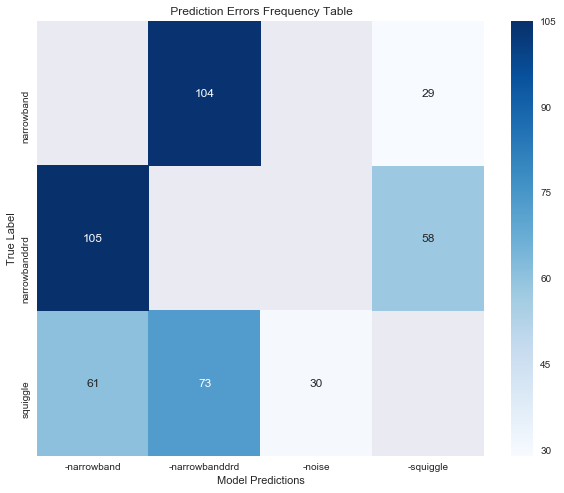

K Nearest Neighbors Error Report
overall accuracy 0.56
              correct  wrong
narrowband        121    118
narrowbandRD      125    131
noise             247      0
squiggle           68    190


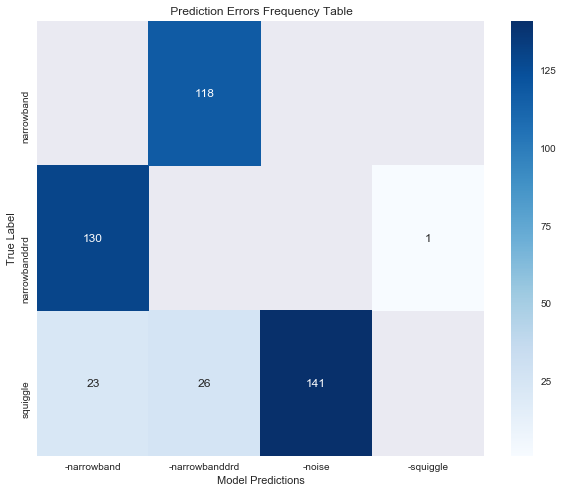

Support Vector Machine Error Report
overall accuracy 0.68
              correct  wrong
narrowband        120    119
narrowbandRD      126    130
noise             247      0
squiggle          189     69


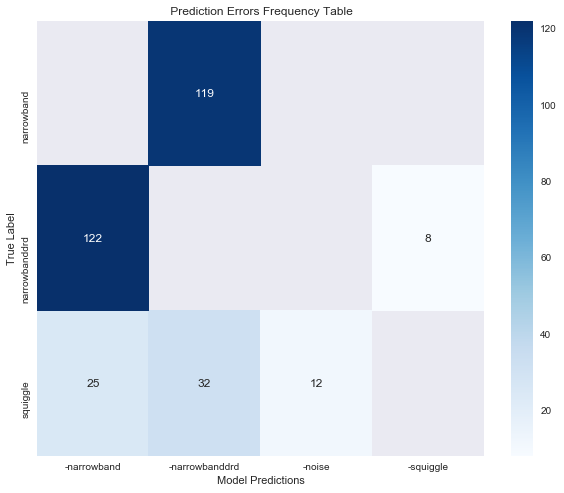

In [13]:
#the best performing models from our grid search  
model_LR = grid_LR.best_estimator_
model_KNN = grid_KNN.best_estimator_
model_SVM = grid_SVM.best_estimator_
names = ['Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine']

#iterate through the tuned models and build error's report 
for j, model in enumerate([model_LR, model_KNN, model_SVM]): 
    print names[j], 'Error Report'
    print 'overall accuracy %.2f' % model.score(testX, testY)
    
    #initialize all the dataframes and arrays 
    y_hat = model.predict(testX) # create predictions on unseen testdata 
    y_hat_pd = pd.DataFrame(data=y_hat)
    testY_pd = pd.DataFrame(data=testY)

    correct_names = [] #all of our correction predictions 
    wrong_labels = [] #of all the images we misclassfied, what were their correct labels?
    wrong_predictions = [] #of all the images we misclassfied, what did we classify them as?

    #append the predictions into lists by correct/wrong 
    for i in range(len(testX)):
        prediction = y_hat_pd.iloc[i].values[0] #get predicted label
        true = testY_pd.iloc[i].values[0] #get the true class label 
        if prediction==true: 
            correct_names.append(prediction)
        else:
            wrong_predictions.append(prediction)
            wrong_labels.append(true)
    wrong_data = np.vstack((wrong_predictions, wrong_labels)) #concat the arrays 

    #tally em' up! 
    correct_nb = correct_names.count('narrowband')
    correct_nbrd = correct_names.count('narrowbanddrd')
    correct_noise = correct_names.count('noise')
    correct_s = correct_names.count('squiggle')

    wrong_nb = wrong_labels.count('narrowband')
    wrong_nbrd = wrong_labels.count('narrowbanddrd')
    wrong_noise = wrong_labels.count('noise')
    wrong_s = wrong_labels.count('squiggle')

    #build into easy-to-read dataframe 
    c = np.vstack([correct_nb, correct_nbrd, correct_noise, correct_s])
    w = np.vstack([wrong_nb, wrong_nbrd, wrong_noise, wrong_s])
    print pd.DataFrame(data=np.hstack([c,w]),
                index=['narrowband', 'narrowbandRD', 'noise', 'squiggle'], 
                columns=['correct', 'wrong'])


    ##--- ERRORS HEATMAP ---##
    model_hm = pd.DataFrame(wrong_data.T, columns=['prediction', 'label'])
    model_hm['freq'] = model_hm['label'].apply(lambda x: 1) #apply layer of ones for error counting 

    model_hm_group = model_hm.groupby(["label", "prediction"]).count() #2x group-by to get error count frequency 
    model_hm_freq = model_hm_group.reset_index() #must reset indeces of groupby 

    model_hm_freq.columns = ['label', 'prediction', '']
    model_hm_group_pivot = model_hm_freq.pivot('label', 'prediction')
    model_hm_group_pivot #similar to a confusion matrix 

    fig = plt.figure(figsize=(10, 8))
    model_hm_heat = sb.heatmap(model_hm_group_pivot,
                          annot=True, #print number on heatmap
                          fmt='g', #no decimals
                          cmap = 'Blues')
    model_hm_heat.set(xlabel='Model Predictions',
                      ylabel='True Label',
                      title=" Prediction Errors Frequency Table") #names[j] + 
    plt.show()

What we are seeing is the true labels on the y-axis, ConvNet predictions on the x-axis, and frequency of those errors as depth of color. What this tells us is that 106 misclassifications on Logistic Regression for Narrowband (N), 93 were for NarrowbandRD (NRD), 0 was for noise, and 13 for squiggles, and so on. 

And so, in general, when there is an error with N/NRD they are misclassfied for eachother. The remainder of the time they are misclassified for squiggles. Also, SVM seems to perform much better on all fronts compared to the other two types, while still leaving about a 50/50 guess when it comes to disttinguishing N and NRD. 

Funneling this knowledge into action means that we need to change our image processing techniques to focus on N/NRD, specifically working to distinguish the two from eachother and, as a lower priority, from squiggles. Getting additional data to boost the n-samples for NRD would be huge, too.